#### Import Modules

In [73]:
import os
import tarfile
import urllib
import joblib # library efficient at serializing large NumPy arrays
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats


# Prepare Data for ML

#### Load Data

In [2]:
def fetch_housing_data(data_url, data_path):
    """Fetch housing tar zipped data file from specific URL into specific data path as CSV file"""
    os.makedirs(data_path, exist_ok=True)
    housing_tgz_path = os.path.join(data_path, "housing.tgz")
    urllib.request.urlretrieve(data_url, housing_tgz_path)
    with tarfile.open(housing_tgz_path) as housing_tgz:
        housing_tgz.extractall(data_path)
    return os.path.join(data_path, "housing.csv")

In [3]:
DATA_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
DATA_PATH = os.path.join("datasets", "housing")

housing_data_csv = fetch_housing_data(DATA_URL, DATA_PATH)
housing_df = pd.read_csv(housing_data_csv)

#### Early Exploration Data

In [4]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


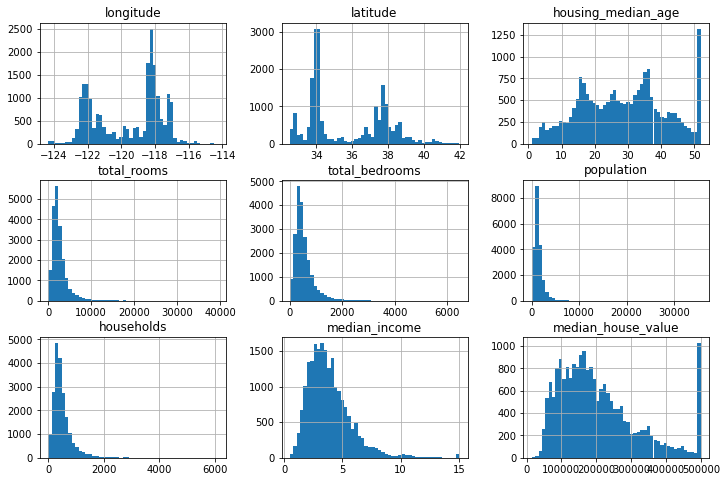

In [7]:
# Visualize

housing_df.hist(bins=50, figsize=(12, 8))
plt.show()

In [8]:
housing_df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### Prepare for Strata Distribution

<AxesSubplot:>

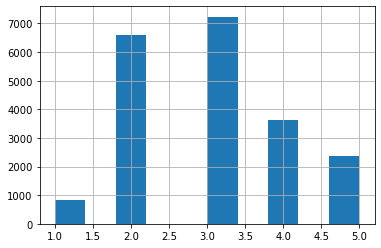

In [9]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"], bins=[0., 1.5, 3., 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing_df["income_cat"].hist()

#### Split train and test (Stratified Split)

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_df = housing_df.loc[train_index]
    strat_test_df = housing_df.loc[test_index]

In [11]:
# Function to compute proportions in overall dataset as well as train and test splits
def compute_proportions(dataset):
    return dataset["income_cat"].value_counts() / len(dataset)

In [12]:
consolidated_proportions_df = pd.DataFrame({
    "Overall": compute_proportions(housing_df),
    "Training Dataset": compute_proportions(strat_train_df),
    "Test Dataset": compute_proportions(strat_test_df)
})

consolidated_proportions_df

,Overall,Training Dataset,Test Dataset
3,0.350581,0.350594,0.350533
2,0.318847,0.318859,0.318798
4,0.176308,0.176296,0.176357
5,0.114438,0.114402,0.114583
1,0.039826,0.039850,0.039729


In [13]:
# Drop income_cat from the dataset

for dataset in (strat_train_df, strat_test_df):
    dataset.drop("income_cat", axis=1, inplace=True)

In [14]:
strat_train_df.columns, strat_test_df.columns

(Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity'],
       dtype='object'),
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity'],
       dtype='object'))

#### Discover & Visualize Data

In [15]:
# Let's create a copy of our stratified train data set to discover and visualize
strat_train_df_copy = strat_train_df.copy()

In [16]:
strat_train_df_copy.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [17]:
strat_train_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

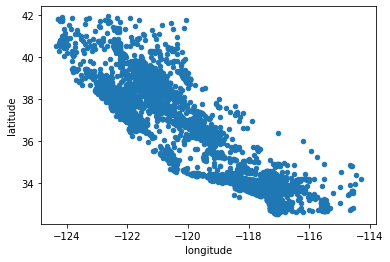

In [18]:
strat_train_df_copy.plot(kind='scatter', x='longitude', y='latitude')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

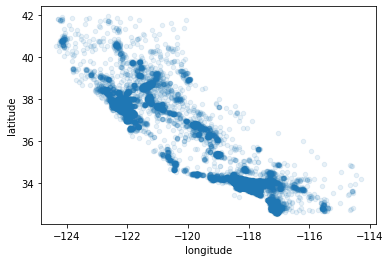

In [19]:
strat_train_df_copy.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1) #to highlight areas with dense data points

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

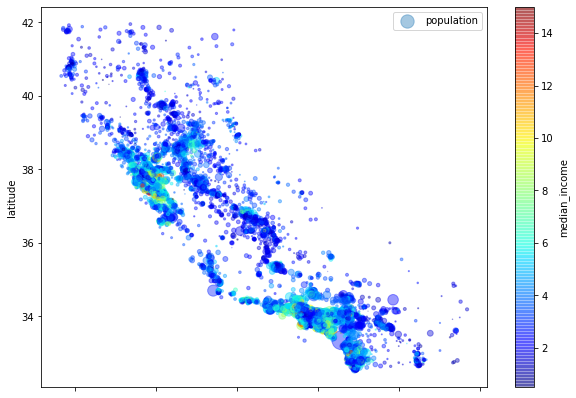

In [20]:
strat_train_df_copy.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=strat_train_df_copy['population']/100, label='population', c='median_income', cmap='jet', figsize=(10, 7))

In [21]:
corr_matrix = strat_train_df_copy.corr()

In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

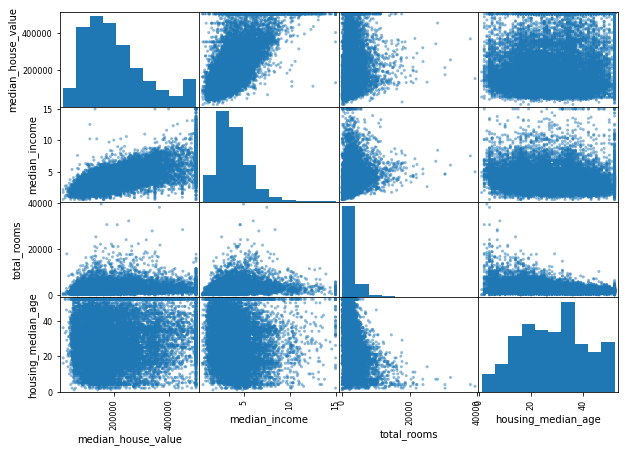

In [23]:
from pandas.plotting import scatter_matrix

attributes_of_interest = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(strat_train_df_copy[attributes_of_interest], figsize=(10, 7))
plt.show()

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

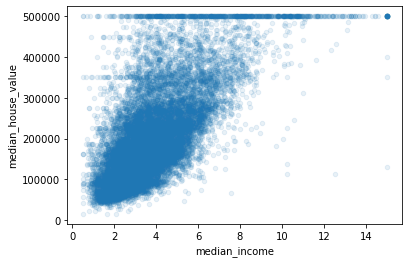

In [24]:
strat_train_df_copy.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [25]:
# Let's examine some potential interesting attributes

strat_train_df_copy['rooms_per_household'] = strat_train_df_copy['total_rooms'] / strat_train_df_copy['households']
strat_train_df_copy['population_per_household'] = strat_train_df_copy['population'] / strat_train_df_copy['households']
strat_train_df_copy['bedrooms_per_room'] = strat_train_df_copy['total_bedrooms'] / strat_train_df_copy['total_rooms']

In [26]:
corr_matrix = strat_train_df_copy.corr()

In [27]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

#### Separate lables and predictors

In [28]:
# housing_train_features = strat_train_df.drop('median_house_value', axis=1)
# housing_train_labels = strat_train_df['median_house_value'].copy()
housing_train_features = strat_train_df.copy()
housing_train_labels = housing_train_features.pop('median_house_value')

In [29]:
housing_train_features.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [30]:
housing_train_labels


17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

#### Separate numeric and categorical features

In [31]:
housing_train_num_features = housing_train_features.drop('ocean_proximity', axis=1)

In [32]:
housing_train_num_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [33]:
housing_train_cat_features = housing_train_features[["ocean_proximity"]]

In [34]:
housing_train_cat_features.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


### Transformation Pipeline

#### Customer Transformer for Adding Attributes

In [35]:
# custom transform for attribute adder

rooms_ix, bedroom_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(TransformerMixin, BaseEstimator):

    def __init__(self, add_bedrooms_per_room=True) -> None: #no *args or **kwargs
        super().__init__()
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self #nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedroom_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

#### Prepare numeric features with numeric pipeline

In [36]:
# Create numeric pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

# housing_train_num_features_prepared = num_pipeline.fit_transform(housing_train_num_features)

#### Create consolidated pipeline

In [37]:
# Lets combine both numeric and categoricial transformation into one

num_attribs = list(housing_train_num_features)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_train_prepared = full_pipeline.fit_transform(housing_train_features)

In [38]:
housing_train_prepared[:2]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

# ML Modeling

#### Linear Regression

In [39]:
# Fit Linear Regression model 
lin_reg = LinearRegression()
lin_reg.fit(housing_train_prepared, housing_train_labels)

LinearRegression()

In [40]:
# Evaluate model - RMSE on training data set
housing_predictions = lin_reg.predict(housing_train_prepared)
lin_mse = mean_squared_error(housing_train_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

#### Decision Tree Regressor

In [41]:
# Fit Decision Tree Regressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_train_prepared, housing_train_labels)

DecisionTreeRegressor()

In [43]:
# Evaluate model - RMSE on training data set
housing_predictions = tree_reg.predict(housing_train_prepared)
tree_mse = mean_squared_error(housing_train_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

#### K-fold cross-validation

In [49]:
# Decision Tree with K-fold cross-validation
tree_reg_kfold = DecisionTreeRegressor()
scores = cross_val_score(tree_reg_kfold, housing_train_prepared, housing_train_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([70829.40447853, 66889.99161952, 70834.40458622, 69357.74714796,
       70513.11595491, 74625.02774866, 72200.65316313, 69934.73732068,
       76398.85120035, 70100.58896437])

In [50]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Standard Deviation: {scores.std()}")

In [51]:
display_scores(tree_rmse_scores)

Scores: [70829.40447853 66889.99161952 70834.40458622 69357.74714796
 70513.11595491 74625.02774866 72200.65316313 69934.73732068
 76398.85120035 70100.58896437]
Mean: 71168.4522184321
Standard Deviation: 2554.852164651316


In [52]:
# Linear Regression with K-fold cross-validation
lin_reg_kfold = LinearRegression()
scores = cross_val_score(lin_reg_kfold, housing_train_prepared, housing_train_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.674001798347


#### Random Forest Regressor

In [54]:
# Fit Random Forest Regressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_train_prepared, housing_train_labels)

RandomForestRegressor()

In [55]:
# Evaluate model - RMSE on training data set
housing_predictions = forest_reg.predict(housing_train_prepared)
forest_mse = mean_squared_error(housing_train_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18557.519268280987

In [56]:
# Random Foreest Regression with K-fold cross-validation
forest_reg_kfold = RandomForestRegressor()
scores = cross_val_score(forest_reg_kfold, housing_train_prepared, housing_train_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [49444.72805593 47219.59883302 49896.08808412 52453.37992953
 49339.32353346 53453.7775051  48806.28886897 47845.25384127
 52944.93835257 49817.96692714]
Mean: 50122.13439310988
Standard Deviation: 2026.287440307967


In [60]:
# Save model with joblib librarary
joblib.dump(forest_reg, "forest_reg.pkl")

['forest_reg.pkl']

## Fine-Tune Model

#### Grid Search

In [63]:
param_grid =[
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_train_prepared, housing_train_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [64]:
# Find the best combination of parameters
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [65]:
# Find the best estimator
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [66]:
# Check evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64775.942518676326 {'max_features': 2, 'n_estimators': 3}
55519.72766809014 {'max_features': 2, 'n_estimators': 10}
53098.55349620179 {'max_features': 2, 'n_estimators': 30}
60483.776693013584 {'max_features': 4, 'n_estimators': 3}
52591.99782238353 {'max_features': 4, 'n_estimators': 10}
50640.110478699666 {'max_features': 4, 'n_estimators': 30}
59323.82446704993 {'max_features': 6, 'n_estimators': 3}
52587.46906545557 {'max_features': 6, 'n_estimators': 10}
50118.45522457687 {'max_features': 6, 'n_estimators': 30}
58306.17500168609 {'max_features': 8, 'n_estimators': 3}
52042.64018023698 {'max_features': 8, 'n_estimators': 10}
50245.6994422519 {'max_features': 8, 'n_estimators': 30}
61165.46816288931 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55011.87858518471 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60028.94193021975 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52791.42814202189 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

#### Randomized Search

In [67]:
# RandomizedSearchCV can be used in much the same way as the GridSearchCV, but instead of trying out
# all possible combinations, it evaluates a given number of random combinations by selecting a random
# value for each hyperparameter at every iteration

#### Ensemble Methods

In [68]:
# Another way to fine tune systems is to try to combine the models that perform
# best. The group ("ensemble") will often outperform better than the best individual
# model (just like Random Forests perform better than the individual Decision Trees)

#### Analyze Best Models and their errors

In [69]:
# Identity the relative importance of the features for the RandomForestRegressor
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.34765345e-02, 7.07466638e-02, 4.27873370e-02, 1.64666058e-02,
       1.68788187e-02, 1.67761829e-02, 1.64154257e-02, 3.59494836e-01,
       4.39466065e-02, 1.08337880e-01, 7.08872577e-02, 1.37544991e-02,
       1.39094928e-01, 1.22874018e-04, 4.73124720e-03, 6.08230330e-03])

In [70]:
# Display feature importances against corresponding feature names
extra_attribs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3594948355027608, 'median_income'),
 (0.13909492789386727, 'INLAND'),
 (0.10833788027598683, 'population_per_household'),
 (0.07347653452569466, 'longitude'),
 (0.07088725774267335, 'bedrooms_per_room'),
 (0.07074666378624693, 'latitude'),
 (0.04394660648607853, 'rooms_per_household'),
 (0.04278733702059439, 'housing_median_age'),
 (0.016878818680883922, 'total_bedrooms'),
 (0.016776182869848385, 'population'),
 (0.016466605824280507, 'total_rooms'),
 (0.01641542574633991, 'households'),
 (0.013754499130735317, '<1H OCEAN'),
 (0.0060823032957479555, 'NEAR OCEAN'),
 (0.004731247200615615, 'NEAR BAY'),
 (0.00012287401764566336, 'ISLAND')]

## Evaluate Model on Test Data

#### Estimate the RMSE on test data

In [71]:
# Capture the final model
final_model = grid_search.best_estimator_

# Get the features and lables from the stratified test dataset
X_test = strat_test_df.copy()
y_test = X_test.pop("median_house_value")

# Run the test feature data through transformation pipeliine
X_test_prepared = full_pipeline.transform(X_test)  # call transform(), not fit_transform() - we do not want to fit the test set! 

# Get the predictions
final_predictions = final_model.predict(X_test_prepared)

# Capture the test rmse
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [72]:
final_rmse

47466.636253476856

#### Estimate the 95% Confidence Interval

In [76]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45463.3078866 , 49388.77150171])

# Launch, Monitor and Maintain